In [28]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image, ImageChops
from sklearn.neighbors import KernelDensity
import random

In [29]:
% matplotlib inline

UsageError: Line magic function `%` not found.


In [30]:
# Create generators for training, validation and testing
# Generate data from the images in a folder, allows use of datasets that do not fit in main memory all at once
# Image resizing is done by the generator so a folder with any sized-images can be used
# The named directory must contain one or more subfolders, path should look like apples_train/apple_class1/img1.jpg...

batch_size = 10
targetsize = (240,240) # 이미지크기
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
train_folder = '/Users/kimtaehyeong/Desktop/anomaly/train' # 훈련 데이터가 있는 폴더 경로 ( 예: './train')
train_generator = train_datagen.flow_from_directory(
    train_folder, # train data path
    target_size = targetsize, 
    batch_size=batch_size,
    class_mode='input'
    )

val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_folder = '/Users/kimtaehyeong/Desktop/anomaly/valid' # 검증 데이터가 있는 폴더 경로
validation_generator = val_datagen.flow_from_directory(
    val_folder, 
    target_size = targetsize,
    batch_size = batch_size,
    class_mode = 'input'
    )

anomaly_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
anomaly_folder = '/Users/kimtaehyeong/Desktop/anomaly/anomaly'
anomaly_generator = anomaly_datagen.flow_from_directory(
    anomaly_folder, 
    target_size= targetsize,
    batch_size = batch_size,
    class_mode = 'input'
    )

Found 1163 images belonging to 1 classes.
Found 760 images belonging to 1 classes.
Found 15 images belonging to 1 classes.


## convloutional autoencoder model
- 모델은 #-------------------- 기준으로 대칭이 되도록 구성
- kernel size, padding, activation, pool_size, layer 수 등은 여러가지로 실험

In [31]:
# Define the convolutional autoencoder model 
# input shape must be the same size as the images that will be fed into it by the generators
# The output layer must be the same dimensions as the original image
inputshape=(240,240,3)
model = Sequential()

model.add(Conv2D(20, (4, 4), padding='same',activation='relu', input_shape=inputshape))
model.add(MaxPooling2D(pool_size=(2,2), padding='same')) # using pool_size (4,4) makes the layer 4x smaller in height and width

model.add(Conv2D(10,(4, 4),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(5,(4, 4),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#-------------------------

model.add(Conv2D(5,(4, 4),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(10,(4, 4),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(20,(4, 4),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3,(3, 3), activation='sigmoid', padding='same'))
#-------------------------

model.summary()

# Compile the model
opt=tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='mean_squared_error')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 240, 240, 20)      980       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 120, 120, 20)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 120, 120, 10)      3210      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 60, 60, 10)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 60, 5)         805       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 5)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 5)        

In [32]:
# Traing the model
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) # Early Stopping (stops training when validation doesn't improve for {patience} epochs))
model_filepath = '/Users/kimtaehyeong/Desktop/anomaly'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only = True, mode = 'min')  # Saves the best version of the model to disk (as measured on the validation data set)
hist=model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        shuffle = True,
        callbacks=[es, save_best])

Epoch 1/50


2021-11-18 15:58:03.911673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - ETA: 0s - loss: 0.0211

2021-11-18 15:58:19.595507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - 20s 165ms/step - loss: 0.0211 - val_loss: 0.0064
INFO:tensorflow:Assets written to: /Users/kimtaehyeong/Desktop/anomaly/assets
Epoch 2/50
117/117 [==============================] - 19s 161ms/step - loss: 0.0052 - val_loss: 0.0044
INFO:tensorflow:Assets written to: /Users/kimtaehyeong/Desktop/anomaly/assets
Epoch 3/50
117/117 [==============================] - 19s 163ms/step - loss: 0.0039 - val_loss: 0.0033
INFO:tensorflow:Assets written to: /Users/kimtaehyeong/Desktop/anomaly/assets
Epoch 4/50
117/117 [==============================] - 19s 162ms/step - loss: 0.0033 - val_loss: 0.0030
INFO:tensorflow:Assets written to: /Users/kimtaehyeong/Desktop/anomaly/assets
Epoch 5/50
117/117 [==============================] - 19s 165ms/step - loss: 0.0029 - val_loss: 0.0027
INFO:tensorflow:Assets written to: /Users/kimtaehyeong/Desktop/anomaly/assets
Epoch 6/50
117/117 [==============================] - 19s 163ms/step - loss: 0.0026 - val_loss: 0.0025
INF

In [33]:
# 모델저장
#model.save('/Users/kimtaehyeong/Documents/detection/model/model1.h5')

In [34]:
# Training continues after improvement stops for the number of epochs equivalent to the 'patience' hyper-parameter
# To get back the model that performed best on the validation set we load the checkpointed model from disk:
model = keras.models.load_model(model_filepath)

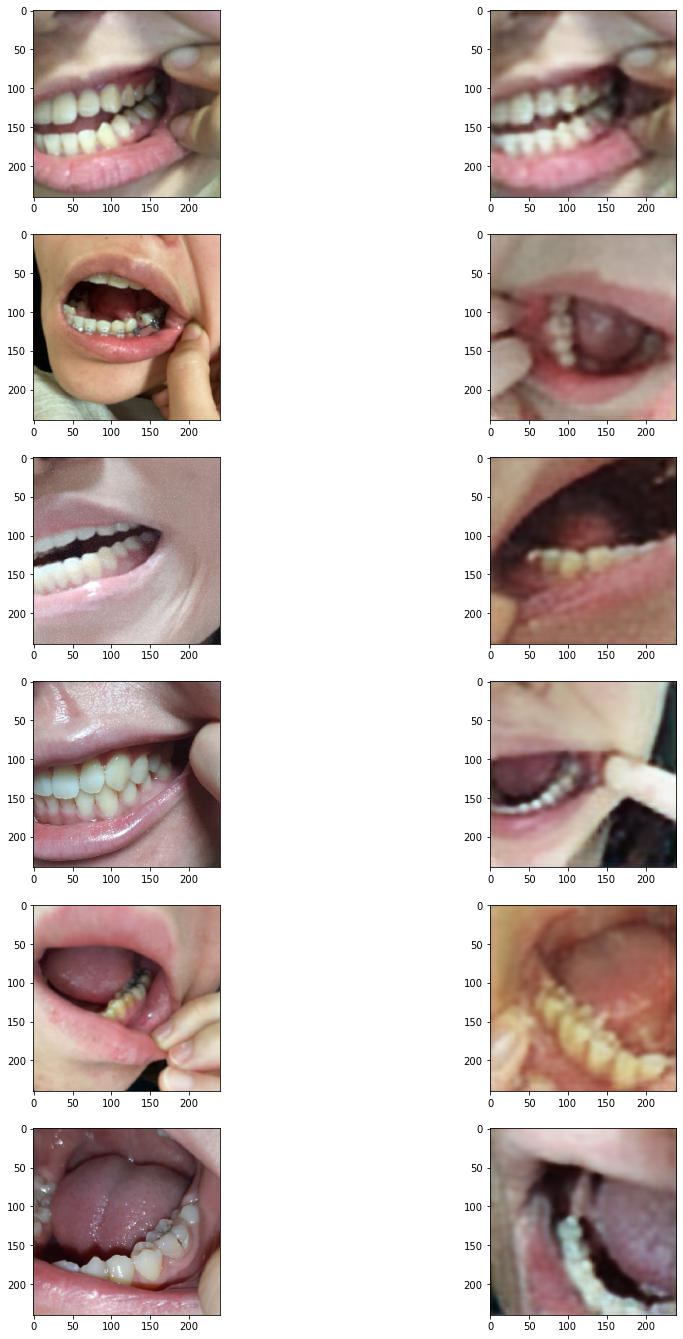

In [49]:
# Test the model by viewing a sample of original and reconstructed images
data_list = []
batch_index = 0
while batch_index <= train_generator.batch_index:
    data = train_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = 6
_, axs = plt.subplots(no_of_samples, 2, figsize=(15, 24))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [36]:
# We want the difference the difference in error between the validation (normal) images and anomalous images to be as high as possible
print(f"Error on validation set:{model.evaluate(validation_generator)}, error on anomaly set:{model.evaluate(anomaly_generator)}")

 1/76 [..............................] - ETA: 15s - loss: 0.0016

2021-11-18 16:15:12.144031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 118ms/step - loss: 0.0093
Error on validation set:0.0013328467030078173, error on anomaly set:0.009346911683678627


In [37]:
# We build a replica of the first half of the auto-encoder (the encoder only)
# This network takes a an image which is 96x96x3 and compresses it down to a 3x3x3 tensor
encoder_replica = Sequential()
encoder_replica.add(Conv2D(20, (4, 4), padding='same',activation='relu', input_shape=(240, 240, 3), weights=model.layers[0].get_weights()) )
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.add(Conv2D(10,(4, 4),activation='relu',  padding='same', weights=model.layers[2].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.add(Conv2D(5,(4, 4),activation='relu',  padding='same', weights=model.layers[4].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 240, 240, 20)      980       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 120, 120, 20)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 120, 120, 10)      3210      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 60, 60, 10)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 60, 60, 5)         805       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 5)         0         
Total params: 4,995
Trainable params: 4,995
Non-trainable params: 0
____________________________________________________

In [38]:
# Creating encoded (compressed versions of the training, validation and anomalous images) and getting their density
# The SKLearn kernel density function only works with 1D arrays so we need to flatten the tensors created by the encoder
img_length = 4500

encoded_images = encoder_replica.predict(train_generator)
encoded_images_flat = [np.reshape(img, (img_length)) for img in encoded_images]

validation_encoded = encoder_replica.predict(validation_generator)
val_enc_flat = [np.reshape(img, (img_length)) for img in validation_encoded]

anom_encoded = encoder_replica.predict(anomaly_generator)
anom_enc_flat = [np.reshape(img, (img_length)) for img in anom_encoded]

2021-11-18 16:15:17.732186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


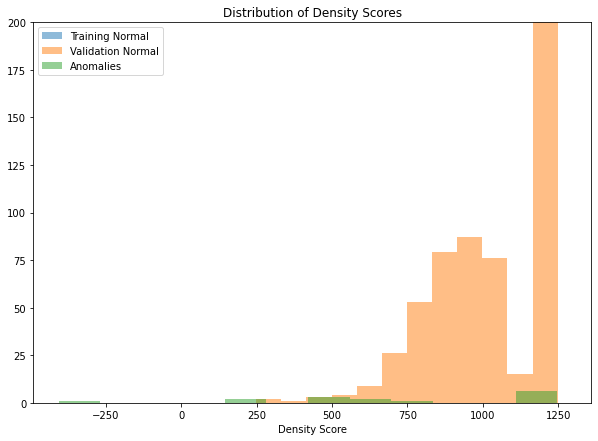

In [39]:
# Kernel Density Estimation of the encoded vectors
kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(encoded_images_flat)
training_density_scores = kde.score_samples(encoded_images_flat) 
validation_density_scores = kde.score_samples(val_enc_flat)
anomaly_density_scores = kde.score_samples(anom_enc_flat)

# Plotting the density distributions of the training (normal), validation (normal) and anomalous images
# Ideally we want to see high separation between the normal and anomalous classes
plt.figure(figsize = (10,7))
plt.title('Distribution of Density Scores')
plt.hist(training_density_scores, 12, alpha=0.5, label='Training Normal')
plt.hist(validation_density_scores, 12, alpha=0.5, label='Validation Normal')
plt.hist(anomaly_density_scores, 12, alpha=0.5, label='Anomalies')
plt.legend(loc='upper left')
plt.xlabel('Density Score')
# plt.xlim(1600,2600)
plt.ylim(0,200)
plt.show()

In [40]:
# Creat a function that will classify whether an unseen image is normal or an anomaly
# Low density and high reconstruction error mean that the image is likely to be anomalous
def check_anomaly(img_path):
    density_threshold = 0 # This threshold was chosen based on looking at the distribution of the density scores of the normal class (validation set)
    reconstruction_error_threshold = 0.003 # This threshold was chosen based on looking at the distribution of reconstruction errors of the normal class
    img  = Image.open(img_path)
    img = np.array(img.resize((240,240), Image.ANTIALIAS))
    img = img / 255
    encoded_img = encoder_replica.predict(np.array([img])) # Create a compressed version of the image using the encoder
    encoded_img = [np.reshape(img, (img_length)) for img in encoded_img] # Flatten the compressed image
    density = kde.score_samples(encoded_img)[0] # get a density score for the new image
#     print(f'density: {density}')
    reconstruction = model.predict(np.array([img]))
    reconstruction_error = model.evaluate(reconstruction,np.array([img]), batch_size = 1)
#     print(f'reconstruction_error: {reconstruction_error}')
    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        return True
    else:
        return False

In [41]:
# Check what proportion of onion images are classified as anomalous
test_path = '/Users/kimtaehyeong/Desktop/anomaly/test/teeth' # test set의 경로 (예: './test2')
test_files = []
for (dirpath, dirnames, filenames) in os.walk(test_path):
    for x in filenames:
        if x.endswith(".jpg"):
            test_files.append(os.path.join(dirpath, x))

test_predictions = []
for file in test_files:
    print(file)
    test_predictions.append(check_anomaly(file))
print(sum(test_predictions)/len(test_predictions))

/Users/kimtaehyeong/Desktop/anomaly/test/teeth/3503_2_6.jpg
1/1 [==============================] - 0s 90ms/step - loss: 0.0032


2021-11-18 16:15:40.178234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-18 16:15:40.293260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


/Users/kimtaehyeong/Desktop/anomaly/test/teeth/3456_2_3.jpg
1/1 [==============================] - 0s 22ms/step - loss: 0.0015
/Users/kimtaehyeong/Desktop/anomaly/test/teeth/3485_2_4.jpg
1/1 [==============================] - 0s 19ms/step - loss: 0.0018
/Users/kimtaehyeong/Desktop/anomaly/test/teeth/3495_2_6.jpg
1/1 [==============================] - 0s 19ms/step - loss: 0.0024
/Users/kimtaehyeong/Desktop/anomaly/test/teeth/3519_2_6.jpg
1/1 [==============================] - 0s 19ms/step - loss: 0.0016
/Users/kimtaehyeong/Desktop/anomaly/test/teeth/3049_2_6.jpg
1/1 [==============================] - 0s 22ms/step - loss: 0.0027
/Users/kimtaehyeong/Desktop/anomaly/test/teeth/3576_2_6.jpg
1/1 [==============================] - 0s 21ms/step - loss: 0.0041
/Users/kimtaehyeong/Desktop/anomaly/test/teeth/3498_2_4.jpg
1/1 [==============================] - 0s 19ms/step - loss: 0.0022
/Users/kimtaehyeong/Desktop/anomaly/test/teeth/3619_2_6.jpg
1/1 [==============================] - 0s 18ms/step

In [42]:
# Check what proportion of onion images are classified as anomalous
anomaly_path = anomaly_folder
anomaly_files = []
for (dirpath, dirnames, filenames) in os.walk(anomaly_path):
    for x in filenames:
        if x.endswith(".jpg"):
            anomaly_files.append(os.path.join(dirpath, x))

anomaly_predictions = []
for file in anomaly_files:
    print(file)
    anomaly_predictions.append(check_anomaly(file))
print(sum(anomaly_predictions)/len(anomaly_predictions))

/Users/kimtaehyeong/Desktop/anomaly/anomaly/non_teeth/KakaoTalk_20211112_185143900_04.jpg
1/1 [==============================] - 0s 19ms/step - loss: 0.0025
/Users/kimtaehyeong/Desktop/anomaly/anomaly/non_teeth/KakaoTalk_20211112_185143900_05.jpg
1/1 [==============================] - 0s 19ms/step - loss: 0.0143
/Users/kimtaehyeong/Desktop/anomaly/anomaly/non_teeth/KakaoTalk_20211112_185143900_13.jpg
1/1 [==============================] - 0s 19ms/step - loss: 0.0029
/Users/kimtaehyeong/Desktop/anomaly/anomaly/non_teeth/KakaoTalk_20211112_185143900_12.jpg
1/1 [==============================] - 0s 20ms/step - loss: 0.0101
/Users/kimtaehyeong/Desktop/anomaly/anomaly/non_teeth/KakaoTalk_20211112_185143900_02.jpg
1/1 [==============================] - 0s 20ms/step - loss: 0.0185
/Users/kimtaehyeong/Desktop/anomaly/anomaly/non_teeth/KakaoTalk_20211112_185143900_01.jpg
1/1 [==============================] - 0s 21ms/step - loss: 0.0041
/Users/kimtaehyeong/Desktop/anomaly/anomaly/non_teeth/정석이네

In [43]:
print(test_predictions)
print(anomaly_predictions)

[True, False, False, False, False, False, True, False, False, False, True, False, False, False, False]
[False, True, False, True, True, True, True, True, True, True, True, False, True, True, True]


In [44]:
test_true = []
for n in range(len(test_files)):
    if test_predictions[n] == True:
        test_true.append(test_files[n])
        
anomaly_true = []
for n in range(len(anomaly_files)):
    if anomaly_predictions[n] == True:
        anomaly_true.append(anomaly_files[n])

In [45]:
print(len(test_true))
print(len(anomaly_true))

3
12


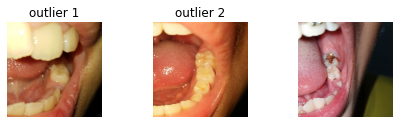

In [46]:
plt.figure(figsize = (10, 8))

for num in range(len(test_true)):
    img = Image.open(test_true[num])
    plt.title('outlier {}'.format(num))
    plt.subplot(4, 4, num+1)
    plt.axis("off")
    plt.imshow(img)

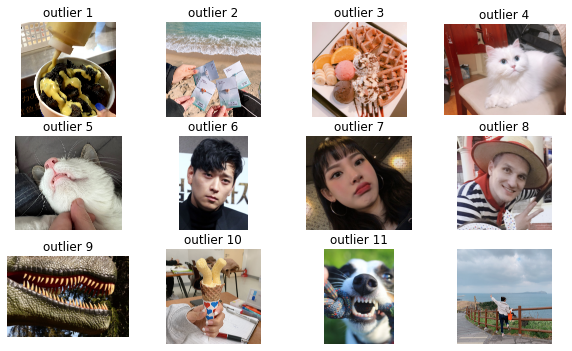

In [47]:
plt.figure(figsize = (10, 8))

for num in range(len(anomaly_true)):
    img = Image.open(anomaly_true[num])
    plt.title('outlier {}'.format(num))
    plt.subplot(4, 4, num+1)
    plt.axis("off")
    plt.imshow(img)